# Potential Talents - Candidate Recommendation Engine
As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

## Data Description:

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

### Attributes:
id : unique identifier for candidate (numeric)
job_title : job title for candidate (text)
location : geographical location for candidate (text)
connections: number of connections candidate has, 500+ means over 500 (text)
Output (desired target):
fit - how fit the candidate is for the role? (numeric, probability between 0-1)
Keywords: “Aspiring human resources” or “seeking human resources”

## Goal(s):
Predict how fit the candidate is based on their available information (variable fit)

### Success Metric(s):
Rank candidates based on a fitness score.
Re-rank candidates when a candidate is starred.

### Bonus(es):
- We are interested in a robust algorithm, tell us how your solution works and show us how your ranking gets better with each starring action.
- How can we filter out candidates which in the first place should not be in this list?
- Can we determine a cut-off point that would work for other roles without losing high potential candidates?
- Do you have any ideas that we should explore so that we can even automate this procedure to prevent human bias?

In [1]:
import pandas as pd
import numpy as np
import string as str
import matplotlib.pyplot as plt
import seaborn as sns
from thefuzz import fuzz, process

In [2]:
data = pd.read_csv('data.csv')

## Preliminary data exploration

In [3]:
data

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
...,...,...,...,...,...
99,100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,NaN
100,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN
101,102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN
102,103,Always set them up for Success,Greater Los Angeles Area,500+,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


- The data has five columns and 104 rows.
- The first column `id` is an unique identifier of candidates.
- Columns `job_title` and `location` are strings respectvely denoting the title of candidate and their location
- The `connection` column is a string but denotes the number of connections a candidate has. This column can be converted to integer after some preprocessing
- Column `fit` contains all null values in the raw dataset. Lateron, this column can be used as an indicator of how strength of candidate fitness against the required job title and location

In [5]:
# Check if the data has dubplicated candidate information
np.sum(data.duplicated(subset=['job_title', 'location', 'connection'])) 

51

There are 51 rows with exactly the same job_title, location, and number of connections. These might be distinct candidates, however, all three attriutes for distinct candidates being same is highly unlikely. We will treat these rows as duplicates and will consider droping them before further analysis and modeling. 

## Data preprocessing

First we'll start by converting the `connection` column to integer. Towards this, we'll convert the string `500+` to 501 and then convert the column to integers

In [6]:
data['connection'].mask(data['connection'] == '500+ ', other='501', inplace=True)
data['connection'] = pd.to_numeric(data['connection'])
data

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,501,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",501,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",501,NaN
...,...,...,...,...,...
99,100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,NaN
100,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",501,NaN
101,102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN
102,103,Always set them up for Success,Greater Los Angeles Area,501,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    int64  
 4   fit         0 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.2+ KB


Now, we'll drop duplicated rows

In [8]:
data = data.drop_duplicates(subset=['job_title', 'location', 'connection'], keep='first').reset_index()
data

,index,id,job_title,location,connection,fit
0,0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,1,2,Native English Teacher at EPIK (English Progra...,Kanada,501,NaN
2,2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,3,4,People Development Coordinator at Ryan,"Denton, Texas",501,NaN
4,4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",501,NaN
5,5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN
6,6,7,Student at Humber College and Aspiring Human R...,Kanada,61,NaN
7,7,8,HR Senior Specialist,San Francisco Bay Area,501,NaN
8,9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,501,NaN
9,10,11,Student at Chapman University,"Lake Forest, California",2,NaN


There are two columns with text data:
1. job_title
2. location

Let's preprocess the location data first

In [9]:
print(data['location'])
print(f"Total: {len(data['location'])}")
print(f"Unique: {len(data['location'].unique())}")

0                          Houston, Texas
1                                  Kanada
2     Raleigh-Durham, North Carolina Area
3                           Denton, Texas
4                          İzmir, Türkiye
5              Greater New York City Area
6                                  Kanada
7                  San Francisco Bay Area
8               Greater Philadelphia Area
9                 Lake Forest, California
10                    Houston, Texas Area
11                       Atlanta, Georgia
12                    Houston, Texas Area
13                      Chicago, Illinois
14                     Austin, Texas Area
15              Jackson, Mississippi Area
16             Greater New York City Area
17    Greater Grand Rapids, Michigan Area
18               Virginia Beach, Virginia
19    Raleigh-Durham, North Carolina Area
20                 Monroe, Louisiana Area
21                    Houston, Texas Area
22                    Greater Boston Area
23                   San Jose, Cal

There are total 53 rows with 41 being unique values. However, upon inspecting we can notice that there are different ways in which the same city is denoted. 

For example, `Houston, Texas` vs `Houston, Texas Area`. 

Now the next objective is to try to bring as many rows as possible in `City, State` format. Let's begin by removing the words: (1) Greater; and (2) Area.

In [10]:
data['location'] = data['location'].str.replace(' Area', '')
data['location'] = data['location'].str.replace('Greater ', '')
data['location']

0                     Houston, Texas
1                             Kanada
2     Raleigh-Durham, North Carolina
3                      Denton, Texas
4                     İzmir, Türkiye
5                      New York City
6                             Kanada
7                  San Francisco Bay
8                       Philadelphia
9            Lake Forest, California
10                    Houston, Texas
11                  Atlanta, Georgia
12                    Houston, Texas
13                 Chicago, Illinois
14                     Austin, Texas
15              Jackson, Mississippi
16                     New York City
17            Grand Rapids, Michigan
18          Virginia Beach, Virginia
19    Raleigh-Durham, North Carolina
20                 Monroe, Louisiana
21                    Houston, Texas
22                            Boston
23              San Jose, California
24                New York, New York
25                 Dallas/Fort Worth
26       Amerika Birleşik Devletleri
2

Next, let's replace *Kanada* by *Canada*. 

There are some rows with location *Amerika Birleşik Devletleri*. In turkish language, *Amerika Birleşik Devletleri* means *United States*. Therefore, let's replace *Amerika Birleşik Devletleri* by *United States*. 

In [11]:
data['location'] = data['location'].str.replace('Amerika Birleşik Devletleri', 'United States')
data['location'] = data['location'].str.replace('Kanada', 'Canada')
data['location']

0                     Houston, Texas
1                             Canada
2     Raleigh-Durham, North Carolina
3                      Denton, Texas
4                     İzmir, Türkiye
5                      New York City
6                             Canada
7                  San Francisco Bay
8                       Philadelphia
9            Lake Forest, California
10                    Houston, Texas
11                  Atlanta, Georgia
12                    Houston, Texas
13                 Chicago, Illinois
14                     Austin, Texas
15              Jackson, Mississippi
16                     New York City
17            Grand Rapids, Michigan
18          Virginia Beach, Virginia
19    Raleigh-Durham, North Carolina
20                 Monroe, Louisiana
21                    Houston, Texas
22                            Boston
23              San Jose, California
24                New York, New York
25                 Dallas/Fort Worth
26                     United States
2

Next, we need to identify different ways of identifying the same city. 

In [12]:
locationSimilarity = np.zeros((data.shape[0], data.shape[0]))
for index, row in data.iterrows():
    tmp = process.extract(row.location, data.location, limit=data.shape[0], scorer=fuzz.token_set_ratio)
    for i in np.arange(len(tmp)):
        location, score, idx = tmp[i]
        locationSimilarity[index][idx] = score            

In [13]:
tmp[10]

('Atlanta', 47, 38)

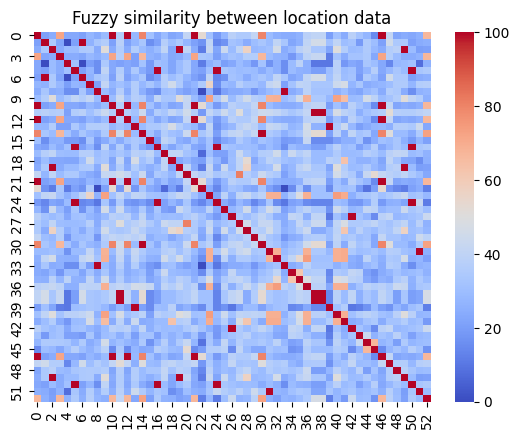

In [14]:
ax = plt.subplot()
sns.heatmap(locationSimilarity, cmap='coolwarm', fmt='g', ax=ax)
ax.set_title('Fuzzy similarity between location data')
plt.show()

Now, we'll replace the locations that are similar to other locations but not identical. While replacing, we'll replace the locations without commas with the ones having commas in their string.

In [15]:
replacements = {}

for location in data['location'].unique():
  # compute the similarity for location
  tmp = process.extract(location, data['location'].unique(), limit=3, scorer=fuzz.token_set_ratio)
  for i in np.arange(len(tmp)):
    # we have a match but the strings are not identical
    if tmp[i][1] > 90 and location != tmp[i][0]:
      # then, we replace the string WITHOUT comma (City name only) with the string WITH the comma (City, State)
      if ',' in location:
        replacements[tmp[i][0]] = location
      elif ',' in tmp[i][0]:
        replacements[location] = tmp[i][0]

for key in replacements.keys():
  data['location'] = data['location'].mask(data['location'] == key, other=replacements[key])

In [16]:
replacements

{'New York City': 'New York, New York',
 'Atlanta': 'Atlanta, Georgia',
 'Chicago': 'Chicago, Illinois',
 'Los Angeles': 'Los Angeles, California'}

Now identify the strings that still do not contain a comma

In [17]:
for location in data['location'].unique():
    if ',' not in location:
        print(location)

Canada
San Francisco Bay
Philadelphia
Boston
Dallas/Fort Worth
United States


In [18]:
data['location'] = data['location'].str.replace('Philadelphia', 'Philadelphia, Pennsylvania')
data['location'] = data['location'].str.replace('Dallas/Fort Worth', 'Dallas, Texas')
data['location'] = data['location'].str.replace('Boston', 'Boston, Massachusetts')
data['location'] = data['location'].str.replace('San Francisco Bay', 'San Francisco, California')

In [19]:
for location in data['location'].unique():
    if ',' not in location:
        print(location)

Canada
United States


In [20]:
# Now that we have (almost) all the locations as city, state
# we split them
city_list = []
state_list = []
country_list = []


for index, row in data.iterrows():
  # compute the similarity for Job Title
  if ',' not in row.location:
    city_list.append('')
    state_list.append('')
    country_list.append(row.location)
  elif 'rkiye' in row.location:
    city, country = row.location.split(', ')
    city_list.append(city)
    state_list.append('')
    country_list.append(country)
  else:
    city, state = row.location.split(', ')
    city_list.append(city)
    state_list.append(state)
    country_list.append('United States')

data['city'] = city_list
data['state'] = state_list
data['country'] = country_list
     


In [21]:
data

,index,id,job_title,location,connection,fit,city,state,country
0,0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,Houston,Texas,United States
1,1,2,Native English Teacher at EPIK (English Progra...,Canada,501,NaN,,,Canada
2,2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina",44,NaN,Raleigh-Durham,North Carolina,United States
3,3,4,People Development Coordinator at Ryan,"Denton, Texas",501,NaN,Denton,Texas,United States
4,4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",501,NaN,İzmir,,Türkiye
5,5,6,Aspiring Human Resources Specialist,"New York, New York",1,NaN,New York,New York,United States
6,6,7,Student at Humber College and Aspiring Human R...,Canada,61,NaN,,,Canada
7,7,8,HR Senior Specialist,"San Francisco, California",501,NaN,San Francisco,California,United States
8,9,10,Seeking Human Resources HRIS and Generalist Po...,"Philadelphia, Pennsylvania",501,NaN,Philadelphia,Pennsylvania,United States
9,10,11,Student at Chapman University,"Lake Forest, California",2,NaN,Lake Forest,California,United States


- Data Exploration
- Duplicates: 51 rows are duplicated = dropped right now. Should we? (same title, location, connections)
- Convert connection column to integer
- Preprocessing of location data
  - Objective: Extract City, State, Country
  - Remove Area
  - Remove Greater
  - Replace Kanada
  - Replace turkish word for USA
  - Fuzzy similarity matrix and heatmap (token_set_ratio)
  - Replace similar but not identical - keep the ones with commas
  - Manual correction for leftover rows
  - Split location into City, State, Country